# Baseline Deep-CF


In [1]:

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from tensorflow import keras
from tensorflow.keras import layers
from pandas import pandas as pd
import numpy as np

In [2]:
#----------METRICAS----------
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import average_precision_score,precision_score
from sklearn.metrics import recall_score

In [3]:
def rel(n):
    if n>0.5:
        return 1
    else:
        return 0
def precision(y_true,y_pred):

    result = y_true-y_pred
    print(result)

def mean_average_precision(y_pred,y_true):

    MAP = []
    N_total = len(y_pred)
    sumatoria_gen = 0.0

    for idx in  range(0,len(y_pred)):
        k = 7

        usuario_test = y_true[idx]
        alfa = 1
        array_7_res_true = {}
        for i in range(0,k):
            array_7_res_true[usuario_test[i][0]] = alfa
            alfa = alfa - 0.14

        usuario = y_pred[idx]
        array_7_res_pred = []

        for i in range(0,k):
            array_7_res_pred.append(usuario[i][0])
        
        sumatoria=0.0
        for place in array_7_res_pred:
            if place in array_7_res_true:
                sumatoria = sumatoria +1*array_7_res_true[place]
        MAP.append(sumatoria/k)
        sumatoria_gen+=sumatoria/k
    
    MAP_average = sumatoria_gen/N_total

    return MAP_average

In [4]:
def mean_reciprocal_rank(y_pred,y_true):
    sum_total = []
    for idx,value in enumerate(y_true):

        #Por usuario 
        array_true = {}
        idx = 0
        for indx, value in enumerate(value):
            place = value[0]
            array_true[place] = indx

        cont = 0
        sumatoria = 0
        for id_,value in enumerate(y_pred[idx],1):
            place_ = value[0]
            if cont<1:
                if place_ in  array_true and cont < 1 : 
                    sumatoria+= 1/id_
                    cont+=1
            else:
                break
        sum_total.append(sumatoria)
    #print(sum_total)
    return (sum(sum_total)/len(sum_total))

In [5]:
def precision_sr(y_pred,y_true):
    sum_total = []
    for idx,value in enumerate(y_true):

        #Por usuario 
        array_true = {}
        idx = 0
        for indx, value in enumerate(value,1):
            place = value[0]
            if indx<8:
                array_true[place] = indx

        cont = 0
        precision = 0
        intersection = 0
        for id_,value in enumerate(y_pred[idx],1):
            place_ = value[0]
            if id_<8:
                if place_ in  array_true : 
                    intersection +=1 
                cont+=1

        precision+= (intersection/cont)
            
        sum_total.append(precision)
    #print(sum_total)
    return (sum(sum_total)/len(sum_total))

In [54]:
def rmse_(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [6]:

from keras.layers import Input, Dense, concatenate

In [7]:
def read_dataset(path = './model_context_pref.csv'):
    dataset = pd.read_csv(path)
    return dataset

def preprocesing(dataset):
    
    user_poi = dataset.iloc[:, 1:3].values
    y = dataset.iloc[:,5:].values
    vocab_size = 300

    #input_ = []
    arr = np.empty((0,2), float)
    for raw in user_poi:
        user = one_hot(str(raw[0]), vocab_size)
        poi = one_hot(str(raw[1]), vocab_size)
        arr = np.vstack((arr, np.array([user[0],poi[0]])))
        #input_.append([user[0],poi[0]])

    return arr,y,user_poi

In [8]:
def model_etapa1(array_hidden_layers,input_,output): #selected the [128→64→32→16→8] hidden layers
    model = keras.Sequential() #model.add(Embedding(4, 8, input_length=32))
    model.add(layers.Dense(units = array_hidden_layers[0], kernel_initializer = 'uniform', activation = 'relu', input_dim = input_))

    for idx in range(1,len(array_hidden_layers)):
        model.add(layers.Dense(units = array_hidden_layers[idx] , kernel_initializer = 'uniform', activation = 'relu'))

    model.add(layers.Dense(units = output, kernel_initializer = 'uniform', activation = 'relu'))

    opt = keras.optimizers.Adam(learning_rate= 0.002)
    model.compile(loss='mean_squared_error', optimizer=opt) #metrics = ['accuracy']

    print(model.summary())
    #print("Number of weights after calling the model:", len(model.weights)) 
    return model

def dnn_etapa2(array_hidden_layers,input_,output): #selected the [128→64→32→16→8] hidden layers
    model = keras.Sequential() #model.add(Embedding(4, 8, input_length=32))
    model.add(layers.Dense(units = array_hidden_layers[0], kernel_initializer = 'uniform', activation = 'relu', input_dim = input_))

    for idx in range(1,len(array_hidden_layers)):
        model.add(layers.Dense(units = array_hidden_layers[idx] , kernel_initializer = 'uniform', activation = 'relu'))

    model.add(layers.Dense(units = output, kernel_initializer = 'uniform', activation = 'relu'))

    opt = keras.optimizers.Adam(learning_rate= 0.002)
    model.compile(loss='mean_squared_error', optimizer=opt) #metrics = ['accuracy']

    print("PESOS: ",model.load_weights)

    #keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

    print(model.summary())
    #model.fit(X_train, y_train, batch_size = 10, epochs = 50)
    #x = tf.ones((1, 4))
    #y = model(x)

    #y_pred = model.predict(X_test)

    #print(y_pred)
    return model
def recomendaciones(y_true,y_pred,user_id_test):
    dict_places = {'1p':0, '2p':1, '3p':2, '4p':3, '5p':4, '6p':5,'7p':6, '8p':7,'9p':8,'10p':9, '11p':10, '12p':11, '13p':12, '14p':13, '15p':14}
    N=7
    matriz_pred = np.zeros((19, 15))
    matriz_true = np.zeros((19, 15))

    for i in range(0,y_pred.shape[0]):
     
        score = y_pred[i][0]  #Se calculo 
        user  = user_id_test[i][0] #id de usuario 
        place  = dict_places[user_id_test[i][1]] #id del place 

        matriz_pred[user][place] = score
        matriz_true[user][place] = y_true[i]
    
    data_pred = pd.DataFrame(matriz_pred, columns = dict_places.keys())
    data_dict_pred = data_pred.to_dict('records')

    data_true = pd.DataFrame(matriz_true, columns = dict_places.keys())
    data_dict_true = data_true.to_dict('records')

    array_pred = []
    array_true = []

    for idx in range(0,len(data_dict_true)):
        array1 = data_dict_true[idx]
        array2 = data_dict_pred[idx]
       
        pred_ = sorted(array2.items(), key=lambda item: item[1], reverse=True)
        true_ = sorted(array1.items(), key=lambda item: item[1], reverse=True)

        array_pred.append(pred_[0:N])
        array_true.append(true_[0:N])

    return array_pred,array_true

# Deep-CF

In [9]:
def dnp_cf(array_hidden_layers,batch_size,epochs):

    #array_hidden_layers = [64,128,256] #64,128 #,32,64
    hidden_layers = array_hidden_layers.reverse() #[256,128,64] #64,128 #,32,64
    #batch_size = 256#512-256
    #epochs = 40
    output = 1

    #Cargar datos de entrenamiento 
    path_train = '../mod_recomendacion/datasetPropuesta/train.csv'
    dataset  = read_dataset(path_train)
    
    inputs_train,y,user_poi_train = preprocesing(dataset) #X y Y entrenamiento 
    """print("train->",inputs_train.shape)
    print("train->",y.shape)"""
    

    #Cargar datos de test
    path_test = '../mod_recomendacion/datasetPropuesta/test.csv'
    dataset_test  = read_dataset(path_test)
    inputs_test,y_test,user_poi_test = preprocesing(dataset_test) #X y Y entrenamiento 
    """print("test->",inputs_test.shape)
    print("test->",y_test.shape)"""
    

    #Train
    model1  = dnn_etapa2(array_hidden_layers,inputs_train.shape[1], 4)
    model1.fit(inputs_train, y, batch_size = batch_size, epochs = epochs)
    y_pred_mod1 = model1.predict(inputs_train)
    print("predict model1 : ",y_pred_mod1.shape)
    
    
    model2= dnn_etapa2(array_hidden_layers,y_pred_mod1.shape[1], 1)
    model2.fit(y_pred_mod1, y, batch_size = batch_size, epochs = epochs)
    y_pred_mod2 = model2.predict(y_pred_mod1)
    print("predict model2: ",y_pred_mod2.shape)


    #TEST
    
    y_pred_mod1_test = model1.predict(inputs_test)
    y_pred_mod2_test = model2.predict(y_pred_mod1_test)
    
    array_pred,array_true = recomendaciones(y_test,y_pred_mod2_test,user_poi_test)
    map_ = mean_average_precision(array_pred,array_true)
    mrk = mean_reciprocal_rank(array_pred,array_true)
    precision = precision_sr(array_pred,array_true)

    #print("-----------------------------------------------")
    #print("--------------------METRICAS ------------------")
    #print("-----------------------------------------------")

    mae  =  mean_absolute_error(y_test,y_pred_mod2_test)
    mse = mean_squared_error(y_test,y_pred_mod2_test)
    mape = mean_absolute_percentage_error(y_test,y_pred_mod2_test)
    

    
    print(" Error Medio Absoluto(MAE) : ", round(mae,3))
    print(" Error cuadratico medio (MSE) : ", round(mse,3)) 
    print(" Error Medio Absoluto(mape) : ", round(mape,3))
    print(" Error cuadratico medio (map_) : ", round(map_,3))
    print(" Error Medio Absoluto(mrk) : ", round(mrk,3))
    print(" Error cuadratico medio (precision) : ", round(precision,3))


    return [mae,mse,mape,map_,mrk,precision]


#dnp_cf()


# Main - Deep CF 

In [12]:
array_hidden_layers = [64,128,256,512] #64,128 #,32,64[8,16,32,64] 
batch_size = 512#512-256
epochs = 50
output = 1
hidden_layers = array_hidden_layers.reverse() #[256,128,64] #64,128 #,32,64

#Cargar datos de entrenamiento 
path_train = '../mod_recomendacion/datasetPropuesta/train.csv'
dataset  = read_dataset(path_train)
inputs_train,y,user_poi_train = preprocesing(dataset) #X y Y entrenamiento 
print(dataset)
    
    

     Unnamed: 0  userid  placeid      pref       act         y
0             0    1338   482954  0.255069  0.495435  0.351215
1             1    1338   580963  0.449491  0.651593  0.530332
2             2    1338   365256  0.788723  0.093860  0.510778
3             3    1338    89504  0.028347  0.835765  0.351315
4             4    1338  1267135  0.432767  0.762280  0.564572
..          ...     ...      ...       ...       ...       ...
495         495    5144    33631  0.540536  0.440251  0.500422
496         496    5144    27884  0.759855  0.842386  0.792867
497         497    5144    29835  0.228560  0.274565  0.246962
498         498    5144    27784  0.706262  0.411643  0.588414
499         499    5144    27784  0.130202  0.195311  0.156245

[500 rows x 6 columns]


In [13]:
#Cargar datos de test
path_test = '../mod_recomendacion/datasetPropuesta/test.csv'
dataset_test  = read_dataset(path_test)
inputs_test,y_test,user_poi_test = preprocesing(dataset_test) #X y Y entrenamiento 
print(dataset_test)

     Unnamed: 0  userid placeid      pref       act         y
0             0       0      1p  0.888889  0.833333  0.869444
1             1       0      2p  0.000000  0.833333  0.291667
2             2       0      3p  1.000000  0.833333  0.941667
3             3       0      4p  0.714286  0.833333  0.755952
4             4       0      5p  0.000000  0.833333  0.291667
..          ...     ...     ...       ...       ...       ...
280         280      18     11p  1.000000  2.333333  1.466667
281         281      18     12p  1.000000  1.583333  1.204167
282         282      18     13p  1.000000  2.333333  1.466667
283         283      18     14p  0.833333  1.583333  1.095833
284         284      18     15p  0.111111  3.000000  1.122222

[285 rows x 6 columns]


In [14]:
#Train
model1  = dnn_etapa2(array_hidden_layers,inputs_train.shape[1], 2)
model1.fit(inputs_train, y, batch_size = batch_size, epochs = epochs)
y_pred_mod1 = model1.predict(inputs_train)
print("predict model1 : ",y_pred_mod1.shape)
    
    
model2= dnn_etapa2(array_hidden_layers,y_pred_mod1.shape[1], 1)
model2.fit(y_pred_mod1, y, batch_size = batch_size, epochs = epochs)
y_pred_mod2 = model2.predict(y_pred_mod1)
print("predict model2: ",y_pred_mod2.shape)


#TEST
    
y_pred_mod1_test = model1.predict(inputs_test)
y_pred_mod2_test = model2.predict(y_pred_mod1_test)

array_pred,array_true = recomendaciones(y_test,y_pred_mod2_test,user_poi_test)


PESOS:  <bound method Model.load_weights of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f74bbb1b310>>
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 174,146
Trainable params: 174,146
Non-trainable params: 0
_________________________________________________________

In [16]:
map_ = mean_average_precision(array_pred,array_true)
mrk = mean_reciprocal_rank(array_pred,array_true)
precision = precision_sr(array_pred,array_true)

#print("-----------------------------------------------")
#print("--------------------METRICAS ------------------")
#print("-----------------------------------------------")
mae  =  mean_absolute_error(y_test,y_pred_mod2_test)
mse = mean_squared_error(y_test,y_pred_mod2_test)
mape = mean_absolute_percentage_error(y_test,y_pred_mod2_test)
    

    
print(" MAE      : ", round(mae,3))
print(" MSE      : ", round(mse,3)) 
print(" MAPE     : ", round(mape,3))
print(" MAP      : ", round(map_,3))
print(" MRK      : ", round(mrk,3))
print(" Precision: ", round(precision,3))

 MAE      :  0.974
 MSE      :  1.057
 MAPE     :  1.0
 MAP      :  0.325
 MRK      :  0.796
 Precision:  0.511


# Test Movilents 

In [15]:
path_train = '../mod_recomendacion/datasetPropuesta/test_movilensTrain.csv'
dataset  = read_dataset(path_train)
print(dataset)

       Unnamed: 0  user   poi  preference  activation  rating
0               0     1     1    0.333333    1.000000    1.00
1               1     1     2    0.888889    0.888889    0.50
2               2     1     3    1.000000    0.333333    0.75
3               3     1     4    0.111111    0.333333    0.50
4               4     1     5    0.111111    0.777778    0.50
...           ...   ...   ...         ...         ...     ...
79995       79995   943  1067    1.000000    0.777778    0.25
79996       79996   943  1074    0.000000    0.333333    0.75
79997       79997   943  1188    0.555556    0.222222    0.50
79998       79998   943  1228    0.888889    1.000000    0.50
79999       79999   943  1330    1.000000    0.000000    0.50

[80000 rows x 6 columns]


In [35]:
inputs_train,y,user_poi_train = preprocesing(dataset) #X y Y entrenamiento
y

array([[1.  ],
       [0.5 ],
       [0.75],
       ...,
       [0.5 ],
       [0.5 ],
       [0.5 ]])

In [36]:
#Cargar datos de test
path_test = '../mod_recomendacion/datasetPropuesta/test_movilensTest.csv'
dataset_test  = read_dataset(path_test)
inputs_test,y_test,user_poi_test = preprocesing(dataset_test) #X y Y entrenamiento 
print(dataset_test)
print(y_test)



       Unnamed: 0  user   poi  preference  activation  rating
0               0     1     6    0.111111    0.444444    1.00
1               1     1    10    0.000000    0.888889    0.50
2               2     1    12    0.555556    0.777778    1.00
3               3     1    14    0.888889    0.000000    1.00
4               4     1    17    0.888889    0.222222    0.50
...           ...   ...   ...         ...         ...     ...
19995       19995   458   648    0.444444    0.222222    0.75
19996       19996   458  1101    1.000000    0.222222    0.75
19997       19997   459   934    1.000000    0.222222    0.50
19998       19998   460    10    0.666667    0.444444    0.50
19999       19999   462   682    0.333333    0.666667    1.00

[20000 rows x 6 columns]
[[1. ]
 [0.5]
 [1. ]
 ...
 [0.5]
 [0.5]
 [1. ]]


# Configuration

In [45]:
def minmax_norm_(df_input):
    return (df_input- df_input.min()) / ( df_input.max() - df_input.min())

In [47]:
def generateValue(f,c):
    df = pd.DataFrame(np.random.randint(0,10,size=(f, c)))
    df = minmax_norm_(df)
    
    return df 

In [50]:
y_mod = generateValue(inputs_train.shape[0],4)
y_mod

,0,1,2,3
0,0.000000,0.333333,0.555556,0.888889
1,0.555556,0.222222,0.555556,0.777778
2,0.888889,0.888889,0.333333,0.000000
3,0.777778,0.666667,0.000000,0.000000
4,0.111111,0.000000,0.222222,0.555556
...,...,...,...,...
79995,0.222222,0.111111,0.111111,0.000000
79996,0.777778,1.000000,0.111111,0.666667
79997,0.333333,0.777778,0.000000,0.777778
79998,0.555556,0.111111,0.444444,0.444444


In [92]:
array_hidden_layers = [128,256,512] #64,128 #,32,64[8,16,32,64] 
batch_size = 256
epochs = 25
output = 1
hidden_layers = [512,256,128,64] #64,128 #,32,64

In [93]:
#Train
model1  = dnn_etapa2(array_hidden_layers,inputs_train.shape[1], 4)
model1.fit(inputs_train, y_mod, batch_size = batch_size, epochs = epochs)
y_pred_mod1 = model1.predict(inputs_train)
    
    
model2= dnn_etapa2(array_hidden_layers,y_pred_mod1.shape[1], 1)
model2.fit(y_pred_mod1, y, batch_size = batch_size, epochs = epochs)
y_pred_mod2 = model2.predict(y_pred_mod1)
print("predict model2: ",y_pred_mod2.shape)

PESOS:  <bound method Model.load_weights of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f74a092db50>>
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_98 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_99 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_100 (Dense)            (None, 512)               131584    
_________________________________________________________________
dense_101 (Dense)            (None, 4)                 2052      
Total params: 167,044
Trainable params: 167,044
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
313/313 [==============================] - 4s 11ms/step - loss: 0.2351
Epoch 2/25
313/313 [=============

In [94]:
#TEST
    
y_pred_mod1_test = model1.predict(inputs_test)
y_pred_mod2_test = model2.predict(y_pred_mod1_test)

#array_pred,array_true = recomendaciones(y_test,y_pred_mod2_test,user_poi_test)

In [95]:
y_pred_mod2_test

array([[0.6375232],
       [0.6375232],
       [0.6375232],
       ...,
       [0.6375232],
       [0.6375232],
       [0.6375232]], dtype=float32)

In [96]:
#print("-----------------------------------------------")
#print("--------------------METRICAS ------------------")
#print("-----------------------------------------------")
mae  =  mean_absolute_error(y_test,y_pred_mod2_test)
mse = mean_squared_error(y_test,y_pred_mod2_test)
rmse = rmse_(y_test,y_pred_mod2_test)

print(" RMSE           : ", round(rmse,3)) 
print(" MSE            : ", round(mse,3)) 
print(" MAE            : ", round(mae,3))
#print(" MAPE           : ", round(mape,3))

 RMSE           :  0.288
 MSE            :  0.083
 MAE            :  0.241


In [104]:
array = [[5,0.288],[10, 0.289],[15, 0.289],[20,0.289],[25,0.288]]

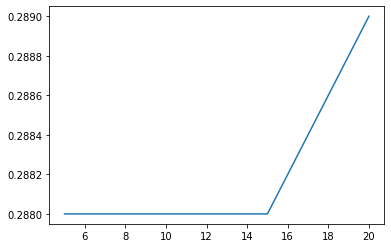

In [84]:
import matplotlib.pyplot as plt
plt.plot([5, 10, 15, 20,25], [0.288, 0.288, 0.288, 0.289,0.288])
plt.show()

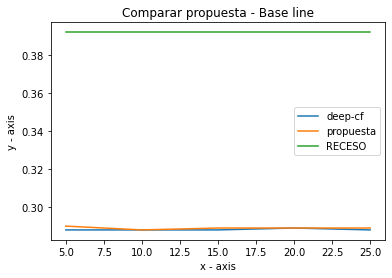

In [3]:
import matplotlib.pyplot as plt
# line 1 points
x1 = [5, 10, 15, 20,25]
y1 = [0.288, 0.288, 0.288, 0.289,0.288]
# plotting the line 1 points 
plt.plot(x1, y1, label = "deep-cf")
x2 = [5, 10, 15, 20,25]
y2 = [0.29, 0.288, 0.289, 0.289,0.289]
# plotting the line 2 points 
plt.plot(x2, y2, label = "propuesta")
x3 = [5, 10, 15, 20,25]
y3 = [0.391951, 0.391951, 0.391951, 0.391951,0.391951]
# plotting the line 1 points 
plt.plot(x3, y3, label = "RECESO")

plt.xlabel('x - axis')
# Set the y axis label of the current axis.
plt.ylabel('y - axis')
# Set a title of the current axes.
plt.title('Comparar propuesta - Base line')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()